## Komposer - Automated Musical Note Generation based on Lyrics with Recurrent Neural Networks

#### D. S. Dias

In [9]:
from __future__ import print_function

import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

batch_size = 64  # Batch size for training.
epochs = 1000  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'music/data-special.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.0)

keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

# Save model
model.save('l2n-1000-special.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

encoder_model.save('l2n-1000-special_encoder.h5')
decoder_model.save('l2n-1000-special_decoder.h5')

Number of samples: 280
Number of unique input tokens: 62
Number of unique output tokens: 40
Max sequence length for inputs: 75
Max sequence length for outputs: 76
Epoch 1/1000
280/280 [==============================] - 4s 14ms/step - loss: 1.7711
Epoch 2/1000
280/280 [==============================] - 2s 8ms/step - loss: 1.3192
Epoch 3/1000
280/280 [==============================] - 2s 8ms/step - loss: 1.2901
Epoch 4/1000
280/280 [==============================] - 3s 11ms/step - loss: 1.2889
Epoch 5/1000
280/280 [==============================] - 4s 13ms/step - loss: 1.2767
Epoch 6/1000
280/280 [==============================] - 3s 10ms/step - loss: 1.2702
Epoch 7/1000
280/280 [==============================] - 3s 11ms/step - loss: 1.2694
Epoch 8/1000
280/280 [==============================] - 3s 12ms/step - loss: 1.2510
Epoch 9/1000
280/280 [==============================] - 3s 12ms/step - loss: 1.2487
Epoch 10/1000
280/280 [==============================] - 3s 10ms/step - loss: 1.242

Epoch 96/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.4059
Epoch 97/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.3894
Epoch 98/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.3848
Epoch 99/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.3947
Epoch 100/1000
280/280 [==============================] - 3s 12ms/step - loss: 0.3787
Epoch 101/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.3867
Epoch 102/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.3647
Epoch 103/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.3702
Epoch 104/1000
280/280 [==============================] - 3s 12ms/step - loss: 0.3551
Epoch 105/1000
280/280 [==============================] - 3s 12ms/step - loss: 0.3687
Epoch 106/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.3406
Epoch 107/1000
280/280 [==============================] - 3s 12

280/280 [==============================] - 5s 17ms/step - loss: 0.0839
Epoch 287/1000
280/280 [==============================] - 4s 14ms/step - loss: 0.0742
Epoch 288/1000
280/280 [==============================] - 4s 14ms/step - loss: 0.0732
Epoch 289/1000
280/280 [==============================] - 4s 15ms/step - loss: 0.0768
Epoch 290/1000
280/280 [==============================] - 5s 16ms/step - loss: 0.0690
Epoch 291/1000
280/280 [==============================] - 4s 16ms/step - loss: 0.0794
Epoch 292/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.0767
Epoch 293/1000
280/280 [==============================] - 3s 12ms/step - loss: 0.0782
Epoch 294/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.0718
Epoch 295/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0692
Epoch 296/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0721
Epoch 297/1000
280/280 [==============================] - 2s 9ms/step 

280/280 [==============================] - 2s 8ms/step - loss: 0.0333
Epoch 478/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0397
Epoch 479/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0460
Epoch 480/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.0437
Epoch 481/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0356
Epoch 482/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0351
Epoch 483/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0664
Epoch 484/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0400
Epoch 485/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.0352
Epoch 486/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0347
Epoch 487/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0356
Epoch 488/1000
280/280 [==============================] - 3s 10ms/step - l

280/280 [==============================] - 2s 9ms/step - loss: 0.0289
Epoch 574/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0275
Epoch 575/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.0315
Epoch 576/1000
280/280 [==============================] - 3s 9ms/step - loss: 0.0350
Epoch 577/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.0258
Epoch 578/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0407
Epoch 579/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0329
Epoch 580/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0252
Epoch 581/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0270
Epoch 582/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0363
Epoch 583/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0368
Epoch 584/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.

280/280 [==============================] - 2s 8ms/step - loss: 0.0381
Epoch 766/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0205
Epoch 767/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 768/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0232
Epoch 769/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0195
Epoch 770/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 771/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 772/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0288
Epoch 773/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0288
Epoch 774/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0184
Epoch 775/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 776/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.

280/280 [==============================] - 2s 8ms/step - loss: 0.0164
Epoch 957/1000
280/280 [==============================] - 2s 8ms/step - loss: 0.0164
Epoch 958/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0191
Epoch 959/1000
280/280 [==============================] - 4s 13ms/step - loss: 0.0336
Epoch 960/1000
280/280 [==============================] - 3s 11ms/step - loss: 0.0172
Epoch 961/1000
280/280 [==============================] - 3s 10ms/step - loss: 0.0164
Epoch 962/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.0167
Epoch 963/1000
280/280 [==============================] - 2s 9ms/step - loss: 0.0168
Epoch 964/1000
280/280 [==============================] - 3s 12ms/step - loss: 0.0169
Epoch 965/1000
280/280 [==============================] - 4s 14ms/step - loss: 0.0232
Epoch 966/1000
280/280 [==============================] - 4s 13ms/step - loss: 0.0316
Epoch 967/1000
280/280 [==============================] - 4s 14ms/step - 

/Volumes/Mac/anaconda2/envs/komposer/lib/python2.7/site-packages/keras/engine/network.py:888: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/Volumes/Mac/anaconda2/envs/komposer/lib/python2.7/site-packages/keras/engine/network.py:888: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_7:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_8:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [10]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 62)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 40)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 326656      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  304128      input_6[0][0]                    
                                                                 lstm_3[0][1]                     
          

In [11]:
print(encoder_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, 62)          0         
_________________________________________________________________
lstm_3 (LSTM)                [(None, 256), (None, 256) 326656    
Total params: 326,656
Trainable params: 326,656
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
print(decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 40)     0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  304128      input_6[0][0]                    
                                                                 input_7[0][0]                    
          

In [13]:
# plot the model
#plot_model(model, to_file='model.png', show_shapes=True)

In [14]:
# summarize model
#plot_model(encoder_model, to_file='encoder_lstm.png', show_shapes=True)

In [15]:
# summarize model
#plot_model(decoder_model, to_file='decoder_lstm.png', show_shapes=True)

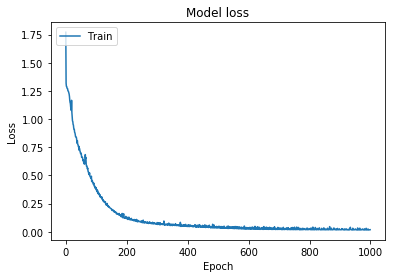

In [51]:
# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [50]:
print (history.history)

{'loss': [1.7711375100272042, 1.3192261184964862, 1.2900513819285802, 1.2888921737670898, 1.2767407723835535, 1.2701502016612463, 1.2693572759628295, 1.2509625060217722, 1.2486987284251623, 1.2426311186381749, 1.2304729904447282, 1.2214074986321586, 1.2015764236450195, 1.1675060817173548, 1.1482017074312483, 1.1381572587149484, 1.106669739314488, 1.0972817999976021, 1.0770943249974931, 1.1668499946594237, 1.0577029296330043, 1.015588743346078, 0.9832754407610212, 0.9775690606662205, 0.9528151665415082, 0.9471382362501962, 0.9206307343074254, 0.9086937478610447, 0.9082128405570984, 0.8821607317243304, 0.8782417297363281, 0.8641336168561663, 0.8439540403229849, 0.841637202671596, 0.8415052022252764, 0.8333847267287118, 0.8083421724183218, 0.7863431743213108, 0.8088376607213702, 0.7761088149888175, 0.7738383037703378, 0.7595394679478237, 0.7514616404260908, 0.7586073858397347, 0.7232557024274554, 0.738838085106441, 0.7173690915107727, 0.7157347593988691, 0.6983035104615348, 0.693005761078

In [17]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [18]:
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    # print('-')
    # print(seq_index)
    print(decoded_sentence[:-2])
    print('w:', input_texts[seq_index])

A | "Am"c2 d | "D7"e>f e | "G"d2 B | "Em"G>
w: ﻿What child is this, who, laid to rest
B | "F"c2 A | A>^G A | "E"B2 ^G | E
w: On Mary's lap is sleeping
A | "Am"c2 d | "D7"e>f e | "G"d2B | "Em"G>
w: Whom angels greet with anthems sweet
"Em"G>A B | "F"c>B A | "E7"^G>F G | "Am"A3 | A3 
w: While shepherds watch are keeping?
"C"g3 | g>f e | "Bm"d2 B | "Em"G>
w: This, this is Christ the King
B | "Am"c2 A | "F"A>^G A | "E"B2 ^G | E3 
w: Whom shepherds guard and angels sing
"C"g3 | g>f e | "Bm"d2 B | "Em"G>
w: This, this is Christ the King
"Em"G>A B | "F"c>B A | "E7"^G>F G | "Am"A3 | A2 |
w: The Babe, the Son of Mary.
A | "Am"c2 d | "D7"e>f e | "G"d2 B | "Em"G>
w: Why lies He in such mean estate
"Em"G>A B | "F"c2 A | A>^G A | "E"B2 ^G 
w: Where ox and ass are feeding?
A | "Am"c2 d | "D7"e>f e | "G"d2 B | "Em"G>
w: Good Christian, fear, for sinners here
"Em"G>A B | "F"c>B A | "E7"^G>F G | "Am"A3 | A3 
w: The silent Word is pleading.
A | "Am"c2 d | "D7"e>f e | "G"d2 B | "Em"G>
w: So bring Him inc

D2 | G4 (3(BAG) | B4 BA | G6- | G4 |
w: Was blind, but now I see.
D2 | G4 (3(BAG) | B4 BA | G4 E2 | D
w: Amazing grace, how sweet the sound
D2 | G4 (3(BAG) | B4 AB | d6- | d
w: That saved a wretch like me.
Bd | d4 (3(BAG) | B4 BA | G4 E2 | D
w: I once was lost, but now am found,
D2 | G4 (3(BAG) | B4 BA | G6- | G4 |
w: Was blind, but now I see.
G | "C"G2 A | (c d) e | "F"c2 c | ("C"A G
w: My latest sun is sinking fast.
G | c2 d | "G"e2 d | "C"c3 | z
w: My race is nearly run.
C | C2 C | (F G A) | "Bb"F2 F | ("F"F C
w: My strongest trials now are past.
G | c2 d | "G"e2 d | "C"c3 | z3 |
w: My triumph has begun.
"A"e3 | e3 | "D"f2 e | d3 
w: O, come, Angel Band.
"G"d3 | d2 c | "C"e2 d | c
w: Come and around me stand.
d | "G"B d d | e d B | "D"A2 B | d
w: O, bear me away on your snow white wings
G | G2 G | "D"B2 A | "G"G3 |
w: to my immortal home.
d | "G"B d d | e d B | "D"A2 B | d
w: O, bear me away on your snow white wings
G | G2 G | "D"B2 A | "G"G3 |
w: to my immortal home.
G | "C"G2 A | 

A | B4 | z2 B G | "D"A4 | z
w: Country roads take me home
B A | "Em"G4 | z2 B d | "C"e4 | z
w: to the place I belong,
e e | "G"d B3 | z2 B G | "D"A B3 | z
w: West Virginia, mountain mama.
B A | "C"G4 | z2 G A | "G"G4 | z4 |
w: Take me home, country roads.
z "Dm"F F F | "C"C
w: I hear her voice.
G A | "G"B B B B | B A G2 | 
w: In the morning hour she calls_ me.
"C"c c c | "G"c B A G | "D"A2 B B | A4 
w: Radio reminds me of my home far a-way.
"Em"B B B B | "F"A A A A | "C"G 
w: Drivin' down the road I get a feeling
A A | "A"A A B A | "E"B c B2 | z
w: that I should have been home yes-ter-day,
A B | c4 | z2 |
w: Yesterday.
z2 "A"E E | F E3 | z2 "F#m"F E | F A3 
w: Almost Heaven. West Virginia.
z2 "D"A A | B A3 | "C"E E E D | "G"E G3 
w: Blue Ridge Mountains. Shennandoah River.
z2 C C | D C3 | "Dm"D F F A | F4 
w: Life is old there, older than the trees,
"C"G G G G | A G3 | "Bb"D F F G | "F"F2 |
w: younger than the mountains, blowing like the breeze.
A | B4 | z2 B G | "D"A4 | z
w: Country r

In [19]:
def generate(lyrics):
    
    abc = "";
    input_lyrics = []
    input_chars = set()
    lines = lyrics.split('\n')
    for line in lines[: len(lines) - 1]:
        input_lyrics.append(line)
        #for char in line:
            #if char not in input_chars:
                #input_chars.add(char)
    
    #input_chars = sorted(list(input_chars))
    #input_tok_index = dict([(char, i) for i, char in enumerate(input_chars)])
    
    encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    
    #print("Token Index: "+ str(len(input_token_index)))
    #print("Input Lyrics: "+ str(len(input_lyrics)))
    
    for seq_index in range(len(input_lyrics)):
        
        for i in range(len(input_lyrics)):
            for t, char in enumerate(input_lyrics[seq_index]):
                encoder_input_data[i, t, input_token_index[char]] = 1.
        
        input_seq = encoder_input_data[seq_index: seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)
        abc += decoded_sentence
        abc += "w: "+input_lyrics[seq_index]+"\n"
    
    return abc

print ("---")
print ("L: 1/4\n"+generate("Hello, is it me? Is it me you're looking for?\n"))



---
L: 1/4
ce | e4 (3(cBA) | c4 cB | A4 F2 | E4
w: Hello, is it me? Is it me you're looking for?



In [53]:
def emptyStringsExistInList(arr):
    
    response = False
    
    for i in arr:
        if (i == ''):
            response = True
    
    return response

def countNotesInSector(sector):
    count = 0
    allowedChars = ['A', 'B', 'C', 'D','E','F','G','a','b','c','d','e','f','g']
    
    for char in allowedChars:
        count += sector.count(char)
    
    return count

def mostCommon(lst):
    return max(set(lst), key=lst.count)

def evaluateConsistency(abc):
    
    consistency = 0.0
    
    lines = abc.split('\n')
    melody_lines = []
    sectors = []
    stripped_sectors = []
    melody_sectors = []
    notes_sector = []
    
    sectors_count = 0
    most_common_count = 0
    
    ## remove lines of lyrics
    for line in lines:
        if (line.startswith('w:') == False):
            melody_lines.append(line)
            
    ## split each line in to sectors
    for melody_line in melody_lines:
        arr = melody_line.split('|')
        for item in arr:
            sectors.append(item)
    
    ## remove trailing and leading empty spaces of sectors
    for sector in sectors:
        stripped_sectors.append(sector.strip())
        
    ## remove empty sectors
    while (emptyStringsExistInList(stripped_sectors)):
        for stripped_sector in stripped_sectors:
            if (stripped_sector == ''):
                stripped_sectors.remove(stripped_sector)
    
    ## remove chords from sectors
    for stripped_sector in stripped_sectors:
        l = stripped_sector.split('"')[1::2]
        if (len(l) > 0):
            melody_sectors.append(stripped_sector.replace('"'+ l[0] +'"',''))
            
    ## count number of notes in each sector
    for melody_sector in melody_sectors:
        notes_sector.append(countNotesInSector(melody_sector))
        
    ## remove single note sectors
    #notes_sector = filter(lambda a: a != 1, notes_sector)
        
    ## count the occurances of most common number of notes in all sectors
    common = mostCommon(notes_sector)
    most_common_count = notes_sector.count(common)
    
    sectors_count = len(notes_sector)
    
    consistency = float(most_common_count)/ float(sectors_count)
    
    return consistency

In [55]:
## Testing Consistency Evaluation Algorithm

#input_lyrics = "So, so you think you can tell\nHeaven from hell\nBlue skies from pain\nCan you tell a green field\nFrom a cold steel rail?\nA smile from a veil?\nDo you think you can tell?";

#print (generate(input_lyrics))
#print ("Consistency: "+ str(evaluateConsistency(generate(input_lyrics))))


#print ("Consistency: "+ str(evaluateConsistency('A/2A/2 | "G"G G G A | B d2 d/2d/2 | "C"e e g g | "G"d3\nw: My Name is Something Something.\nA/2A/2 | "G"G G G A | B d2 d/2d/2 | "C"e e g g | "G"d3\nw: My Name is Something Something.\nA/2A/2 | "G"G G G A | B d2 d/2d/2 | "C"e e g g | "G"d3\nw: My Name is Something Something.\nA/2A/2 | "G"G G G A | B d2 d/2d/2 | "C"e e g g | "G"d3\nw: My Name is Something Something.')))


Consistency: 0.666666666667
